In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from IPython.display import Image
%matplotlib inline
plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams['font.size'] = 15

In [3]:
def n_complex(n = 1, s = 1):
    return 1/np.sqrt(2)*np.random.randn(n) + 1.0j*1/np.sqrt(2)*np.random.randn(n)
def normalize_cl(cl):
    return np.array([l*(l+1)/(2*np.pi)*cl[l-1] for l in range(1,len(cl) + 1)])
def remove_norm(Cl):
    return np.array([2*np.pi*1/l/(l+1)*Cl[l-1] for l in range(1,1+len(Cl))])

### import ps from class output

In [2]:
files = ['/global/u2/i/iameric/class/output/test_cl_lensed.dat']
data = []
for data_file in files:
    data = np.loadtxt(data_file)
#1:l     2:TT      3:EE       4:TE      5:BB   6:phiphi       7:TPhi      8:Ephi
names = ['l','TT','EE','BB','TE','phiphi','Tphi','Ephi']

# l starts with 2 in class's output ps
# let Cl=0 when l = 1
l = data[:,0]
TT = remove_norm(np.insert(data[:,1],0,0))
EE = remove_norm(np.insert(data[:,2],0,0))
BB = remove_norm(np.insert(data[:,3],0,0))
TE = remove_norm(np.insert(data[:,4],0,0))

### import Planck T map

In [8]:
nilc = fits.open('../maps/COM_CompMap_CMB-nilc_2048_R1.20.fits')
T_nilc = hp.reorder(nilc[1].data.field(0), n2r = True)

In [55]:
#truncate to nside = 1024
nside = 1024
T_nilc_trun = hp.pixelfunc.ud_grade(T_nilc, nside)
alm_T = hp.map2alm(T_nilc_trun, lmax = 3000)
# use TT from the planck NILC map
TT = hp.anafast(T_nilc, lmax = 3000)

## create alm_E that is consistent with the TE, EE, and T map.
from the formula in BK1

$
\begin{equation}
a_{lm}^E = \frac{Cl^{TE}}{Cl^{TT}}a_{lm}^T + \sqrt{Cl^{EE} - (Cl^{TE})^2/Cl^{TT}} n_{lm}
\end{equation}
$

In [56]:
size = len(alm_T)
nlm = n_complex(size)

Alm = hp.Alm()
lmax = Alm.getlmax(len(alm_T))
alm_E = np.zeros_like(alm_T)
for i, alm in enumerate(alm_T):
    l = Alm.getlm(lmax, i)[0]
    alm_E[i] = TE[l-1]/TT[l-1]*alm_T[i] + np.sqrt(EE[l-1] - TE[l-1]**2/TT[l-1])*nlm[i]
    if alm_E[i] != alm_E[i]:
        alm_E[i] = 0

/global/u2/i/iameric/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in sqrt


In [57]:
alm_B = hp.synalm(BB, lmax = lmax)

In [58]:
maps = hp.alm2map((alm_T, alm_E, alm_B), nside = nside)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


### create the derivative maps

In [59]:
# dermap[0] is the original map, dermap[1], [2] are derivative with respect to theta and phi. (d_phi is devided with sin(theta))
Tmap, d_theta, d_phi = hp.alm2map_der1(alm_T, nside = nside)

# create a map of sin(theta), to get rid of the sin(theta) in the d_phi map.
#With this, we can create maps of the second derivative
sin_theta = np.sin(hp.pix2ang(nside = nside, ipix = range(hp.nside2npix(nside)))[0])
cos_theta = np.cos(hp.pix2ang(nside = nside, ipix = range(hp.nside2npix(nside)))[0])
d_phi = d_phi*sin_theta

#create second derivative maps
dermap_tt, dermap_tp = hp.alm2map_der1(hp.map2alm(d_theta),nside = nside)[1:]
dermap_tp = dermap_tp*sin_theta
dermap_pp = hp.alm2map_der1(hp.map2alm(d_phi), nside = nside)[2]
dermap_pp = dermap_pp*sin_theta

### T

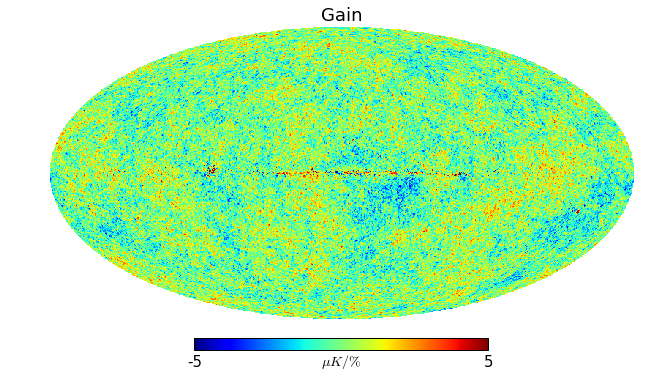

In [60]:
# Gain template 
T_normalized = 0.01*Tmap
hp.mollview(T_normalized, unit = r'$\mu K/\%$',title = 'Gain', min = -5, max = 5)

### $\nabla_{\theta} T$

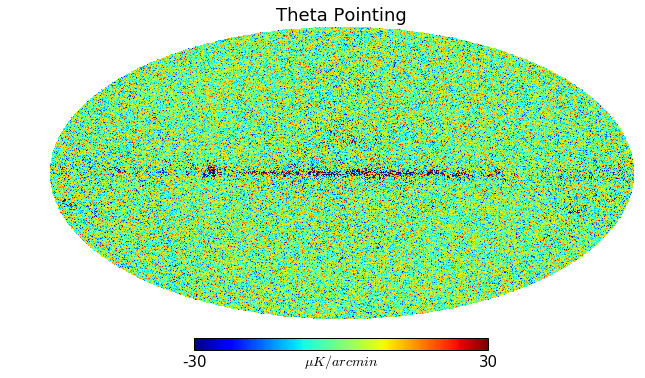

In [61]:
# Pointing theta
d_t_normalized = d_theta*np.pi /180./60.
hp.mollview(d_t_normalized, unit = r'$\mu K/arcmin$', title='Theta Pointing',min = -30, max = 30)

### $\nabla_{\phi} T$

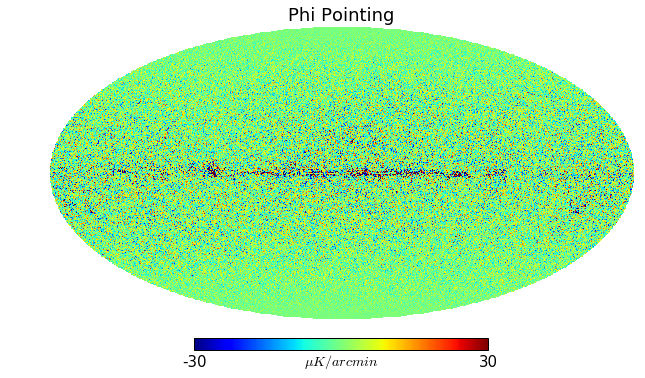

In [62]:
# Pointing phi
d_p_normalized = d_phi*np.pi /180./60. 
hp.mollview(d_p_normalized, unit = r'$\mu K/arcmin$', title='Phi Pointing',min = -30, max = 30)

### $\nabla_{\theta \phi} T$

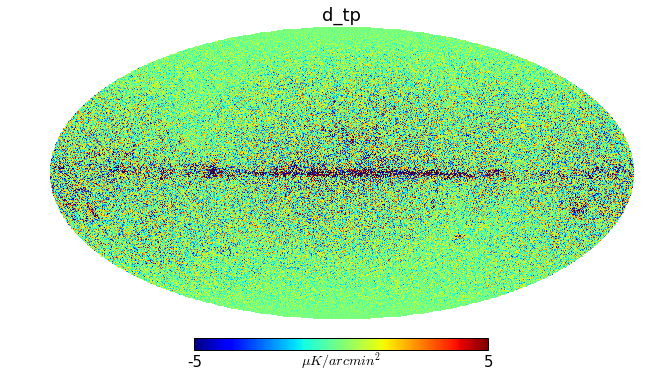

In [68]:
d_tp_normalized = dermap_tp *(np.pi /180./60.)**2 
hp.mollview(d_tp_normalized, unit = r'$\mu K/arcmin^2$', title='d_tp', min = -5, max = 5)

### $\nabla_{\phi \phi} T$

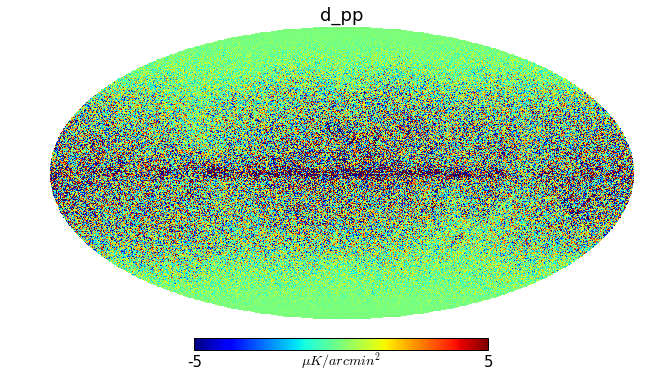

In [67]:
d_pp_normalized = dermap_pp *(np.pi /180./60.)**2 
hp.mollview(d_pp_normalized, unit = r'$\mu K/arcmin^2$', title='d_pp', min = -5, max = 5)

### $\nabla_{\theta \theta} T$

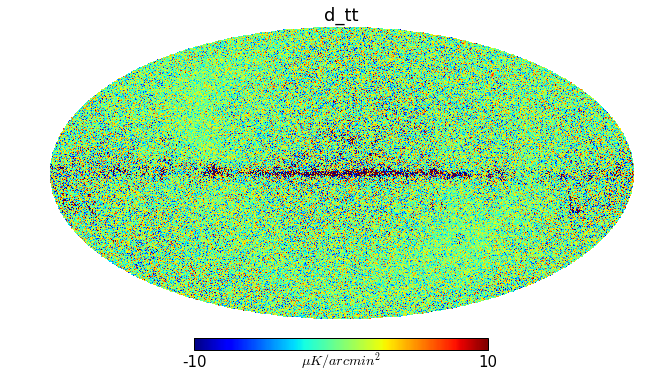

In [66]:
d_tt_normalized = dermap_tt *(np.pi /180./60.)**2 
hp.mollview(d_tt_normalized, unit = r'$\mu K/arcmin^2$', title='d_tt', min = -10, max = 10)

### save maps to fits 

In [69]:
hp.write_map('../maps/T.fits',Tmap, fits_IDL=False)
hp.write_map('../maps/d_p.fits',d_phi, fits_IDL=False)
hp.write_map('../maps/d_t.fits',d_theta, fits_IDL=False)
hp.write_map('../maps/d_tt.fits',dermap_tt, fits_IDL=False)
hp.write_map('../maps/d_tp.fits',dermap_tp, fits_IDL=False)
hp.write_map('../maps/d_pp.fits',dermap_pp, fits_IDL=False)

In [70]:
test = hp.read_map('../maps/d_p.fits')

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
